In [109]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow_datasets as tfds
import tqdm

import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [110]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [111]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')

#category = "googleDataset"

url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
test_images = images[10000:12000]

141545 images to train on


In [112]:
images.shape

(141545, 784)

In [113]:
def prepare_data(data):
    data = tf.data.Dataset.from_tensor_slices(data.reshape(len(data), 28,28,1))
    #data = tf.data.Dataset.from_tensor_slices(data)
    
    #reshape
    #data = data.map(lambda img: tf.reshape(img, (28,28,1)))

    data = data.map(lambda img: (tf.cast(img, tf.float32)))

    # normalize input to gaussian distribution or divide by 128
    data = data.map(lambda img: ((img/128)-1))

    # keep the progess in memory
    data = data.cache()
    #mnist = mnist.shuffle(1000) 
    data = data.batch(32) # 32 image in one batch
    data = data.prefetch(20) # prepare 20 next datapoints 

    return data

In [114]:
train_ds = prepare_data(train_images)
test_ds = prepare_data(test_images)
train_ds.take(1)

<TakeDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

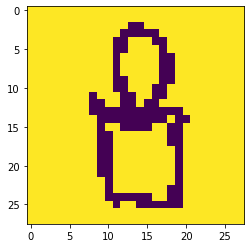

In [115]:
for x in train_ds.take(1):
  img = tf.cast(tf.floor(x*128+1), tf.uint32)[-1,:,:,-1]
  plt.imshow(img)

**The Model**

In [116]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.layers_list = [
      #tf.keras.layers.Input(shape=(32,28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28,28,1)), 
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'), 
      tf.keras.layers.GlobalMaxPool2D(),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ]

  def __call__(self, img, training = False):
    for layer in self.layers_list:
      img = layer(img, training=training)
    return img 

In [117]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()

    self.transposed_layers_list = [
        tf.keras.layers.Dense(7*7*64, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((7, 7, 64)),
        tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='tanh')
    ]

  def __call__(self, x, training = False):
    for layer in self.transposed_layers_list:
        x = layer(x, training = training)
    return x
    


In [118]:
class GAN(tf.keras.Model):
  def __init__(self):
    super(GAN, self).__init__()

    self.metrics_list = [
                        tf.keras.metrics.Mean(name="discriminator_loss"),
                        tf.keras.metrics.Mean(name="generator_loss") 
                       ]
    self.optimizer_disc = tf.keras.optimizers.Adam()
    self.optimizer_gen = tf.keras.optimizers.Adam()
    self.loss = tf.keras.losses.BinaryCrossentropy()

    self.generator = Generator()
    self.discriminator = Discriminator()

    #2. call method (forward computation)
  def call(self, img, noise = tf.random.normal([32,1,100]), training = False):
    # create fake image with generator
    # store fake image in gen_fake_img
    gen_fake_image = self.generator(noise, training = training)
    # feed it to dicriminator
    # store prediction in fake_img
    fake_img = self.discriminator(gen_fake_image, training = training)
    # feed real image to discriminator
    # store prediction in img
    img = self.discriminator(img, training = training) 
    return img, fake_img, gen_fake_image
    

  #3. metrics property
  @property
  def metrics(self):
    # return a list with all metrics in the model
    return self.metrics_list


  #4 reset all metrics object
  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset_states()

  def train_step(self, data):
    noise = tf.random.normal([32,1,100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #its possible to use just one gradient tape with tf.GradientTape(persistent = True)
      # call the GAN model
      imgPrediction, fake_imgPrediction, gen_fake_image = self(x, noise, training = True) 
      # create targets
      imgTarget, fake_imgTarget = tf.ones_like(imgPrediction), tf.zeros_like(fake_imgPrediction) #we could do this outside of gradientTape, with tf.ones instead of tf.ones_like

      # calculate the discriminator loss
      imgLoss = self.loss(imgTarget, imgPrediction)
      fake_imgLoss = self.loss(fake_imgTarget, fake_imgPrediction)
      discriminator_loss = fake_imgLoss + imgLoss

      # calculate the generator loss
      generator_loss = self.loss(tf.ones_like(fake_imgPrediction), fake_imgPrediction)

    gen_gradients = gen_tape.gradient(generator_loss, self.generator.trainable_variables)
    disc_gradients = disc_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)
    self.optimizer_gen.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
    self.optimizer_disc.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

    # update metrics
    self.metrics[0].update_state(discriminator_loss)
    self.metrics[1].update_state(generator_loss)
    return {m.name : m.result() for m in self.metrics}, gen_fake_image

  def test_step(self, data):
    noise = tf.random.normal([32,1,100])

    # call model and create targets 
    imgPrediction, fake_imgPrediction, gen_fake_image = self(x, noise, training = False) 
    imgTarget, fake_imgTarget = tf.ones_like(imgPrediction), tf.zeros_like(fake_imgPrediction) 

    # calculate the loss
    imgLoss = self.loss(imgTarget, imgPrediction)
    fake_imgLoss = self.loss(fake_imgTarget, fake_imgPrediction)
    discriminator_loss = fake_imgLoss + imgLoss

    generator_loss = self.loss(tf.ones_like(fake_imgPrediction), fake_imgPrediction)

    # update metrics
    self.metrics[0].update_state(discriminator_loss)
    self.metrics[1].update_state(generator_loss)

    return {"val_" + m.name : m.result() for m in self.metrics}, gen_fake_image

In [119]:
model_test = GAN() 

model_test(tf.keras.Input((28,28,1)), tf.keras.Input((1,100)))

model_test.summary()

Model: "gan_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_14 (Generator)    multiple                  0 (unused)
                                                                 
 discriminator_14 (Discrimin  multiple                 0 (unused)
 ator)                                                           
                                                                 
Total params: 395,078
Trainable params: 388,546
Non-trainable params: 6,532
_________________________________________________________________


In [120]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, img_summary_writer, save_path): 

  # 1. iterate over epochs
  img = []
  for epoch in range(epochs):

    # 2. train step over all batches in training data
    for data in tqdm.tqdm(train_ds):
      metrics, generated_fake_image = model.train_step(data)


    # 3. log and print training metrics 
    with train_summary_writer.as_default():
      tf.summary.scalar(name = "discriminator_loss", data = metrics["discriminator_loss"], step = epoch)
      tf.summary.scalar(name = "generator_loss", data = metrics["generator_loss"], step = epoch)

    print(metrics.items())

    # 4. rest metrics
    model.reset_metrics()

    # 5. evaluate on validation data
    for data in val_ds:
      metrics, generated_fake_image = model.test_step(data)

    img.append(generated_fake_image)
    # 6. log validation metric 
    with val_summary_writer.as_default():
      tf.summary.scalar(name = "val_discriminator_loss", data = metrics["val_discriminator_loss"], step = epoch)
      tf.summary.scalar(name = "val_generator_loss", data = metrics["val_generator_loss"], step = epoch)

    with img_summary_writer.as_default():
      #tensorflow can handle floats in image, we dont have to cast back to int
      tf.summary.image(name = "generated_fake_image", data = tf.reshape(generated_fake_image, (-1, 28, 28, 1)), step = epoch)

    print(metrics.items())

    # 7. reset metric objects
    model.reset_metrics()

  #8. save models weights
  model.save_weights(save_path)

  # 9. plot generated image for each epoch
  no_subplot = 1
  for x in img:
    x = tf.cast(tf.floor(x*128+1), tf.uint32)[-1,:,:,-1]
    plt.subplot(1,10,no_subplot)
    plt.imshow(x, cmap = 'gray')
    plt.axis('off')
    no_subplot += 1

In [121]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_path = f"logs/train/"
val_log_path = f"logs/val/"
img_log_path = f"logs/img/"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path + current_time)
# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path + current_time)

img_summary_writer = tf.summary.create_file_writer(img_log_path + current_time)


100%|██████████| 313/313 [01:21<00:00,  3.82it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.12199862>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=3.4593759>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=2.1447585>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.1447971>)])


100%|██████████| 313/313 [01:21<00:00,  3.82it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.01954305>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=5.287057>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.34065303>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=1.6915325>)])


100%|██████████| 313/313 [01:21<00:00,  3.82it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.012027404>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=5.651688>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.11582822>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=3.166764>)])


100%|██████████| 313/313 [01:21<00:00,  3.82it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.011502011>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=6.170632>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.033458136>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=6.565122>)])


100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.0060540903>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=6.443069>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.4577736>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=6.2472444>)])


100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.0049868347>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=6.878602>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.07393301>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=3.5928006>)])


100%|██████████| 313/313 [01:21<00:00,  3.82it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.0042057447>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=6.9875417>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=1.0845153>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.5653268>)])


100%|██████████| 313/313 [01:21<00:00,  3.82it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.0023877067>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=7.138022>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.07986958>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=9.767504>)])


100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.0014804385>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=7.4488516>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.07181645>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=6.795386>)])


100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


dict_items([('discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.0011779555>), ('generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=7.7392173>)])
dict_items([('val_discriminator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.0048444695>), ('val_generator_loss', <tf.Tensor: shape=(), dtype=float32, numpy=7.2492943>)])


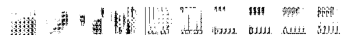

In [122]:
model = GAN()
epochs=10

#2. choose a path to save the weights
save_path = "trained_model"

training_loop(model, train_ds, test_ds, 10, train_summary_writer, val_summary_writer, img_summary_writer, save_path)